# Neoclassical transport calculations for axisymmetric plasmas

## `SymbolicEquilibrium`

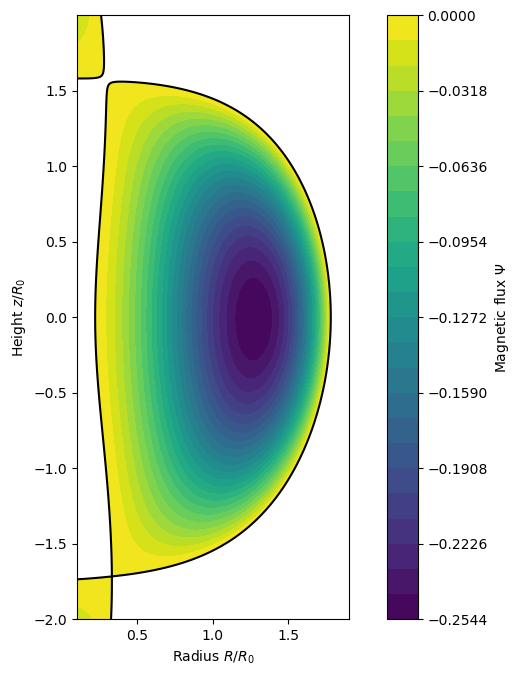

In [16]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 0.32, "A": -0.155, "elongation": 1.7, "triangularity": 0.33}
eq = SymbolicEquilibrium(**NSTX_single_null,
                         B0=NSTX_Bt0.si.value, # TODO handle quantity input
                         config="single-null")
rminmaxstep=(0.1, 1.9, 0.001) # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep=(-2, 2, 0.001)
eq.plot(
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep
);

## `FluxSurface`

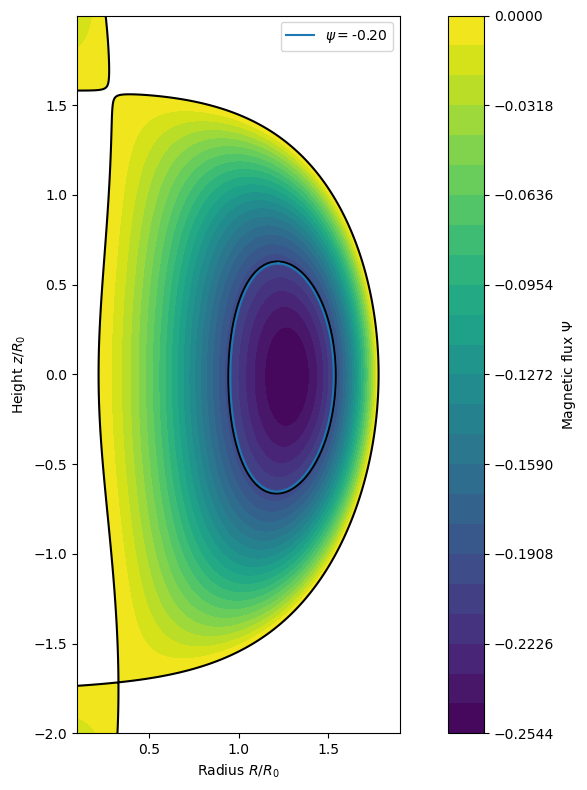

In [19]:
ax = eq.plot(
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep
)
flux_surface = eq.get_flux_surface(
    psi_value=-0.2,
    # TODO allow either psi_value or rho_value
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep
                                  ) #TODO call this by effective_radius
flux_surface.plot(ax, n=True)
plt.tight_layout()
# plt.savefig("/home/dominik/Writing/blog/images/fluxsurface.png")

## Define particles in our simulation

In [3]:
import astropy.units as u
import numpy as np

from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)

<IonizationStateCollection for: H, C>

In [4]:
import xarray

In [ ]:
rho = np.linspace(0, 1, 50)

## Multiple flux surfaces - radial grid

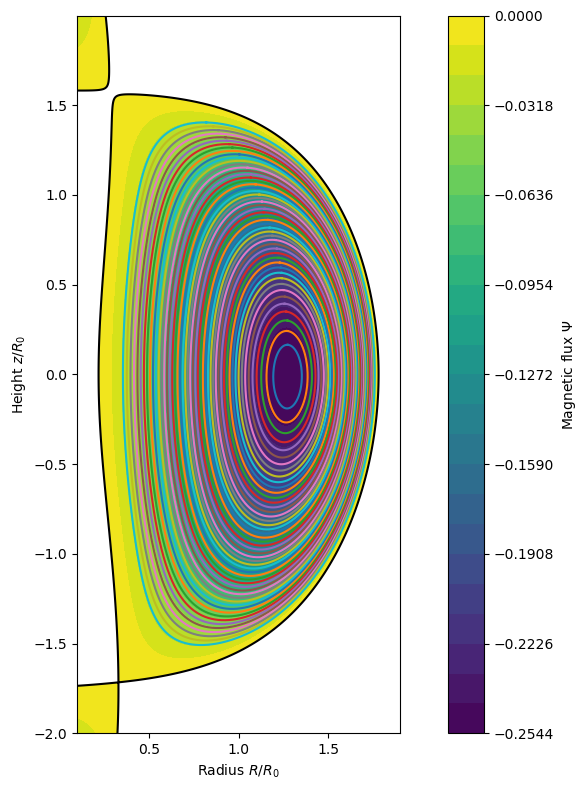

In [32]:
ax = eq.plot(
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep
)
psi = np.linspace(-0.25, -0.023, 50)
surfaces = list(eq.get_multiple_flux_surfaces(psi,
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep
                                       ))  # TODO handle multiple contours; just find closed ones
for fs in surfaces:
    fs.plot(ax)
ax.legend().remove()
plt.tight_layout()
# plt.savefig("/home/dominik/Writing/blog/images/fluxsurfacegrid.png")

## `FlowCalculator`

In [28]:
surfaces[0]

FluxSurface(R=array([1.27394038, 1.27334778, 1.27234833, ..., 1.27534667, 1.27434722,
       1.27394038]), Z=array([0.16445875, 0.16449647, 0.16453253, ..., 0.16434116, 0.16443274,
       0.16445875]), psi=-0.25, Brvals=array([-0.03875354, -0.03874911, -0.03873553, ..., -0.03875775,
       -0.03875654, -0.03875354]), Bzvals=array([0.00184877, 0.00121277, 0.00013945, ..., 0.0033579 , 0.00228559,
       0.00184877]), Bphivals=array([0.29949229, 0.29963168, 0.29986704, ..., 0.29916205, 0.29939668,
       0.29949229]), Bprimervals=array([0.07284229, 0.05522852, 0.02546492, ..., 0.11449098, 0.08492156,
       0.07284229]), Bprimezvals=array([0.22379685, 0.22300461, 0.22152707, ..., 0.22542649, 0.22430493,
       0.22379685]), GradRho2=array([0.03775374, 0.03766123, 0.03753947, ..., 0.0380429 , 0.03782904,
       0.03775374]))

In [133]:
rho_to_surface = {rho: surfaces[i] for i, rho in enumerate(rho)};

In [38]:
rho = psi / psi.min() # TODO
# also TODO my rho is already normalized

array([1.        , 0.98146939, 0.96293878, 0.94440816, 0.92587755,
       0.90734694, 0.88881633, 0.87028571, 0.8517551 , 0.83322449,
       0.81469388, 0.79616327, 0.77763265, 0.75910204, 0.74057143,
       0.72204082, 0.7035102 , 0.68497959, 0.66644898, 0.64791837,
       0.62938776, 0.61085714, 0.59232653, 0.57379592, 0.55526531,
       0.53673469, 0.51820408, 0.49967347, 0.48114286, 0.46261224,
       0.44408163, 0.42555102, 0.40702041, 0.3884898 , 0.36995918,
       0.35142857, 0.33289796, 0.31436735, 0.29583673, 0.27730612,
       0.25877551, 0.2402449 , 0.22171429, 0.20318367, 0.18465306,
       0.16612245, 0.14759184, 0.12906122, 0.11053061, 0.092     ])

In [64]:
import jax.numpy as jnp

In [123]:
from jax import grad, vmap

In [124]:
rhoj = jnp.array(rho)
T0 = 10 #* u.eV
Ta = 0 #* u.eV

def T_i_func(rho, T0=T0, Ta=Ta):
    T_i = ((T0 - Ta) * (1 - rho**2) - Ta)#.to(u.K, equivalencies = u.temperature_energy())
    return T_i

T_i = T_i_func(rhoj)
T_e = T_i
ne_0 = 1e20# * u.m**-3
ne_a = 1e18# * u.m**-3
def n_e_func(rho, ne_0=ne_0, ne_a=ne_a):
    n_e = (ne_0 - ne_a) * (1 - rho**2)**0.5 + ne_a
    return n_e
n_e = n_e_func(rhoj)
n_i = n_e # TODO
n_C6 = np.full_like(n_e, 1e19)# * u.m**-3)

array([1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19, 1.e+19,
       1.e+19, 1.e+19], dtype=float32)

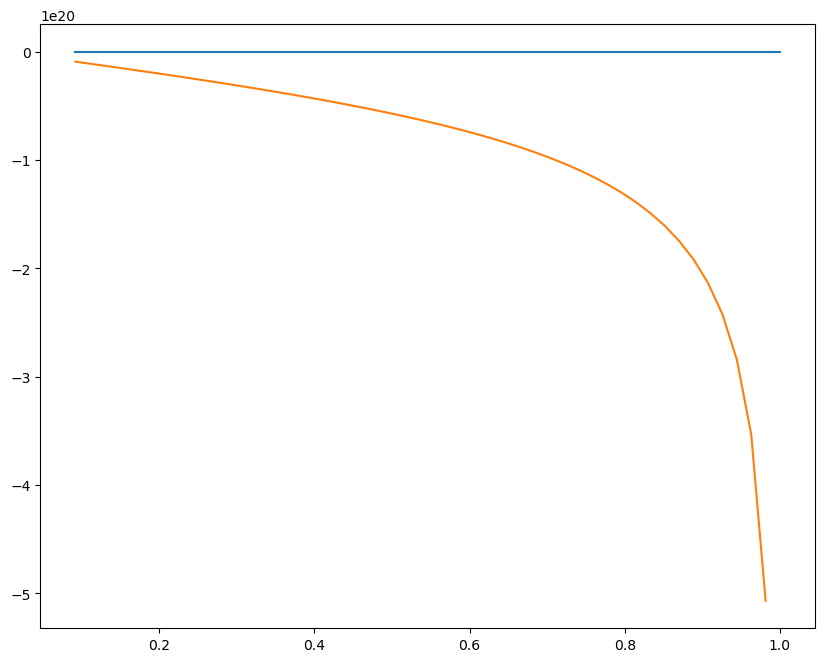

In [125]:
dTi = vmap(grad(T_i_func))(rho)
dn_e = vmap(grad(n_e_func))(rho)
plt.plot(rho, dTi)
plt.plot(rho, dn_e)

In [135]:
import xarray

dataset_H1 = xarray.Dataset({"T": ("rho", T_i),
                             "gradT": ("rho", dTi),
                             "n": ("rho", n_e),
                             "gradn": ("rho", dn_e),
                            },
                            coords={"rho": rho, "particle": "H 1+"},
                            attrs={"T unit": u.eV,
                                   "n unit": u.m**-3,
                                   "spatial gradient unit": u.m,
                                  }
                           )

dataset_C6 = xarray.Dataset({"T": ("rho", T_i),
                             "gradT": ("rho", dTi),
                             "n": ("rho", n_C6),
                             "gradn": ("rho", jnp.zeros_like(n_C6)),
                            },
                            coords={"rho": rho, "particle": "C 6+"},
                            attrs={"T unit": u.eV,
                                   "n unit": u.m**-3,
                                   "spatial gradient unit": u.m,
                                  }
                           )
dataset_e = xarray.Dataset({"T": ("rho", T_e),
                             "gradT": ("rho", dTi),
                             "n": ("rho", n_e),
                             "gradn": ("rho", dn_e),
                            },
                            coords={"rho": rho, "particle": "e-"},
                            attrs={"T unit": u.eV,
                                   "n unit": u.m**-3,
                                   "spatial gradient unit": u.m,
                                  }
                           )

dataset = xarray.concat([dataset_H1, dataset_C6, dataset_e], dim='particle')

<xarray.Dataset>
Dimensions:   (particle: 3, rho: 50)
Coordinates:
  * rho       (rho) float64 1.0 0.9815 0.9629 0.9444 ... 0.1291 0.1105 0.092
  * particle  (particle) <U4 'H 1+' 'C 6+' 'e-'
Data variables:
    T         (particle, rho) float32 0.0 0.3672 0.7275 ... 9.833 9.878 9.915
    gradT     (particle, rho) float32 -20.0 -19.63 -19.26 ... -2.211 -1.84
    n         (particle, rho) float32 1e+18 1.997e+19 ... 9.939e+19 9.958e+19
    gradn     (particle, rho) float32 -inf -5.071e+20 ... -1.101e+19 -9.147e+18
Attributes:
    T unit:                 eV
    n unit:                 1 / m3
    spatial gradient unit:  m

In [141]:
dataset.sel(particle=dataset.particle.str.startswith("C"))

<xarray.Dataset>
Dimensions:   (particle: 1, rho: 50)
Coordinates:
  * rho       (rho) float64 1.0 0.9815 0.9629 0.9444 ... 0.1291 0.1105 0.092
  * particle  (particle) <U4 'C 6+'
Data variables:
    T         (particle, rho) float32 0.0 0.3672 0.7275 ... 9.833 9.878 9.915
    gradT     (particle, rho) float32 -20.0 -19.63 -19.26 ... -2.211 -1.84
    n         (particle, rho) float32 1e+19 1e+19 1e+19 ... 1e+19 1e+19 1e+19
    gradn     (particle, rho) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    T unit:                 eV
    n unit:                 1 / m3
    spatial gradient unit:  m

In [165]:
index = 1
this_rho_dataset = dataset.isel(rho=index)
this_rho_dataset

# TODO make FlowCalculator take flux surface and this

<xarray.Dataset>
Dimensions:   (particle: 3)
Coordinates:
    rho       float64 0.9815
  * particle  (particle) <U4 'H 1+' 'C 6+' 'e-'
Data variables:
    T         (particle) float32 0.3672 0.3672 0.3672
    gradT     (particle) float32 -19.63 -19.63 -19.63
    n         (particle) float32 1.997e+19 1e+19 1.997e+19
    gradn     (particle) float32 -5.071e+20 0.0 -5.071e+20
Attributes:
    T unit:                 eV
    n unit:                 1 / m3
    spatial gradient unit:  m

In [ ]:
all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)

In [130]:
from plasmapy.transport.flows import FlowCalculator

density_gradient = {
    "H 1+": 1e18 * u.m ** -3 / u.m,
    "C 1+": 1e18 * u.m ** -3 / u.m,
}
temperature_gradient = {
    "H 1+": (-1 * u.eV).to(u.K, equivalencies=u.temperature_energy()) / u.m,
    "C 1+": (-1 * u.eV).to(u.K, equivalencies=u.temperature_energy()) / u.m,
}

fc = FlowCalculator(all_species, flux_surface, density_gradient, temperature_gradient)

KeyboardInterrupt: 

### Units

In [6]:
sym = "H 1+"
S_pt = fc.S_pt[sym]

<Quantity [ 0.00128004, -0.00467272,  0.        ] J2 / (A m6)>

In [7]:
Aai = fc.Aai[sym]

<Quantity [[-1.24280783,  1.55273521, -1.68617992],
           [ 1.55273521,  4.00408902,  4.64710622],
           [-1.68617992,  4.64710622, -7.80444627]] kg / (m3 s)>

In [8]:
H = fc.all_species["H"]

<IonizationState instance for H>

In [9]:
(S_pt / Aai).si

<Quantity [[-0.00102996, -0.00300935, -0.        ],
           [ 0.00082438, -0.00116699,  0.        ],
           [-0.00075913, -0.00100551, -0.        ]] V / m>

### Bootstrap current

In [10]:
fc.bootstrap_current.si  # TODO should be A/m^2? missing a magnetic field in the denominator somewhere?

<Quantity -0.02879324 Pa / m>

In [11]:
(fc.bootstrap_current / u.T).to(u.A / u.m ** 2)

<Quantity -0.02879324 A / m2>

### Fluxes

The units are horribly off for each of them atm.

In [12]:
flux_unit = u.m ** -2 / u.s

Unit("1 / (m2 s)")

In [13]:
fc._fluxes_BP

{'H 1+': Fluxes(particle_flux=<Quantity -7.98501624e+15 1 / (m2 s)>, heat_flux=<Quantity 0.04670417 kg / s3>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.14384766e+09 1 / (m2 s)>, heat_flux=<Quantity -1.78151124e-10 kg / s3>)}

In [14]:
fc._fluxes_BP["H 1+"].particle_flux.to(flux_unit)

<Quantity -7.98501624e+15 1 / (m2 s)>

In [15]:
fc._fluxes_BP["H 1+"].heat_flux.to(u.J * flux_unit)

<Quantity 0.04670417 J / (m2 s)>

In [16]:
fc._fluxes_CL

{'H 1+': Fluxes(particle_flux=<Quantity -1.12773871e+15 Pa / m5>, heat_flux=<Quantity -0.00453989 kg2 / (m4 s4)>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.63916787e+14 Pa / m5>, heat_flux=<Quantity -8.14217635e-05 kg2 / (m4 s4)>)}

In [17]:
(fc._fluxes_CL["H 1+"].particle_flux / (u.kg / u.s / u.m ** 4)).to(flux_unit)

<Quantity -1.12773871e+15 1 / (m2 s)>

In [18]:
(fc._fluxes_CL["H 1+"].heat_flux / (u.kg / u.s / u.m ** 4)).to(u.J * flux_unit)

<Quantity -0.00453989 J / (m2 s)>

In [19]:
fc._fluxes_PS

{'H 1+': Fluxes(particle_flux=<Quantity -7.31905529e+15 Pa / m4>, heat_flux=<Quantity -0.02946402 kg2 / (m3 s4)>),
 'C 6+': Fluxes(particle_flux=<Quantity 1.06382447e+15 Pa / m4>, heat_flux=<Quantity -0.00052843 kg2 / (m3 s4)>)}

In [20]:
(fc._fluxes_PS["H 1+"].particle_flux / (u.kg / u.s / u.m ** 3)).to(flux_unit)

<Quantity -7.31905529e+15 1 / (m2 s)>

In [21]:
(fc._fluxes_PS["H 1+"].heat_flux / (u.kg / u.s / u.m ** 3)).to(u.J * flux_unit)

<Quantity -0.02946402 J / (m2 s)>

In [22]:
flux_unit = u.m ** -2 / u.s

Unit("1 / (m2 s)")

In [23]:
[
    (flux[sym].particle_flux.unit.si / flux_unit).si
    for flux in [fc._fluxes_BP, fc._fluxes_CL, fc._fluxes_PS]
]

[Unit(dimensionless), Unit("kg / (m4 s)"), Unit("kg / (m3 s)")]

In [24]:
[
    (flux[sym].heat_flux.unit / flux_unit / u.J).si
    for flux in [fc._fluxes_BP, fc._fluxes_CL, fc._fluxes_PS]
]

[Unit(dimensionless), Unit("kg / (m4 s)"), Unit("kg / (m3 s)")]